In [2]:
import torch
import numpy as np

from torch import nn, optim
import torch.nn.functional as F
from sklearn.preprocessing import OneHotEncoder

import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# Define a model:
class Network(nn.Module):
    def __init__(self, vocab, n_hidden, n_layers, do=0.5):
        super().__init__()
        
        self.vocab    = vocab
        self.int2char = {i: ch for i, ch in enumerate(vocab)}
        self.char2int = {ch: i for i, ch in self.int2char.items()}
        self.encoder  = OneHotEncoder(sparse=False).fit(vocab.reshape(-1, 1))
        
        self.n_hidden = n_hidden 
        self.n_layers = n_layers
        self.lstm = nn.LSTM(len(vocab), n_hidden, n_layers, batch_first=True, dropout=do)
        self.fc   = nn.Linear(n_hidden, len(vocab))
        
    def forward(self, x, hs=None):
        x, hs = self.lstm(x, hs)          # -> (batch_size, seq_len, n_hidden)
        x = x.reshape(-1, self.n_hidden)  # -> (batch_size * seq_len, n_hidden)
        out = self.fc(x)                  # -> (batch_size * seq_len, vocab_size)
        
        return out, hs 
    
    def predict(self, char, top_k=None, hs=None):
        device = 'cuda' if torch.cuda.is_available() else 'cpu'
        self.to(device)
        self.eval()
        
        with torch.no_grad():
            x = np.array([char])
            x = x.reshape(-1, 1)
            x = self.onehot_encode(x)
            x = x.reshape(1, 1, -1)
            x = torch.tensor(x, dtype=torch.float32)
            x = x.to(device)

            out, hs = self(x, hs)

            ps   = F.softmax(out, dim=1).squeeze()
            
            if top_k is None:
                choices = np.arange(len(self.vocab))
            else:
                ps, choices = ps.topk(top_k)
                choices = choices.cpu().numpy()
            
            ps = ps.cpu().numpy()
            
            char = np.random.choice(choices, p=ps/ps.sum())
            char = self.int2char[char]

        return char, hs
    
    
    def sample(self, length, top_k=None, primer='And Victoria sang '):
        hs = None
        for px in primer:
            out, hs = self.predict(px, hs=hs)
        
        chars = [ch for ch in primer]
        for ix in range(length):
            char, hs = self.predict(chars[-1], top_k=top_k, hs=hs)
            chars.append(char)
        
        return ''.join(chars)
    
    
    def label_encode(self, data):
        return np.array([self.char2int[ch] for ch in data])
    
    
    def label_decode(self, data):
        return np.array([self.int2char[i] for i in data])
    
    
    def onehot_encode(self, data):
        return self.encoder.transform(data)
    
    
    def onehot_decode(self, data):
        return self.encoder.inverse_transform(data)
        
        

In [4]:
# define a batching method:
def get_batches(data, n_seq, seq_len):
    """
    Takes data of shape (n_samples, n_features), returns batches
    of shape (n_seq, seq_len, n_features)
    """
    n_features = data.shape[1]
    n_chars    = n_seq * seq_len
    n_batches  = int(np.floor(len(data) / n_chars))
    n_keep     = n_batches * n_chars
    
    inputs  = data[:n_keep]
    targets = np.append(data[1:], data[0]).reshape(data.shape)
    targets = targets[:n_keep]
    
    inputs = inputs.reshape(n_seq, -1, n_features)
    targets = targets.reshape(n_seq, -1, n_features)
    
    for i in range(0, inputs.shape[1], seq_len):
        x = inputs[:, i: i + seq_len]
        y = targets[:, i: i + seq_len]
        yield x,y
        

In [5]:
def train(model, data, batch_size, seq_len, epochs, lr=0.01, clip=5, valid=None):
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    model = model.to(device)
    
    opt = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()

    if valid is not None:
        data  = model.onehot_encode(data.reshape(-1, 1))
        valid = model.onehot_encode(valid.reshape(-1, 1))
    else:
        data  = model.onehot_encode(data.reshape(-1, 1))

    train_loss = []
    valid_loss = []
    
    for e in range(epochs):
        model.train()
        hs = None
        t_loss = 0
        v_loss = 0

        for x, y in get_batches(data, batch_size, seq_len):
            opt.zero_grad()
            x = torch.tensor(x).float()
            x = x.to(device)
            
            out, hs = model(x, hs)
            hs = tuple([h.data for h in hs])

            # invert one-hot of targets for use by cross-entropy loss function
            y = y.reshape(-1, len(model.vocab))
            y = model.onehot_decode(y)
            y = model.label_encode(y.squeeze())
            y = torch.from_numpy(y).long().to(device)

            loss = criterion(out, y.squeeze())
            loss.backward()
            nn.utils.clip_grad_norm_(model.parameters(), clip)
            opt.step()
            
            t_loss += loss.item()
            
        if valid is not None:
            model.eval()
            hs = None
            with torch.no_grad():
                for x, y in get_batches(valid, batch_size, seq_len):

                    x = torch.tensor(x).float()
                    x = x.to(device)

                    # invert one-hot of targets for use by cross-entropy loss function
                    y = y.reshape(-1, len(model.vocab))
                    y = model.onehot_decode(y)
                    y = model.label_encode(y.squeeze())
                    y = torch.from_numpy(y).long().to(device)

                    out, hs = model(x, hs)
                    hs = tuple([h.data for h in hs])

                    loss = criterion(out, y.squeeze())
                    v_loss += loss.item()

                valid_loss.append(np.mean(v_loss))
        
        train_loss.append(np.mean(t_loss))
        
        if e % 2 == 0:
            print(f'------- Epoch {e} ---------')
            print(f'Training Loss: {train_loss[-1]}')
            if valid_loss:
                print(f'Valid Loss: {valid_loss[-1]}')
            
    plt.plot(train_loss, label="Training")
    plt.plot(valid_loss, label="Validation")
    plt.title("Loss vs Epochs")
    plt.legend()
    plt.show()

In [6]:
# get data from file:
with open('data/texts/anna.txt') as data:
    text = data.read()

# get unique characters in text 
vocab = np.array(sorted(set(text)))

# split training and validation sets. Convert text to NumPy arrays
split_idx = int(np.floor(0.1 * len(text)))
trainset = np.array(list(text[:-split_idx]))
validset = np.array(list(text[-split_idx:]))
trainset.shape, validset.shape

((1786701,), (198522,))

In [7]:
n_hidden = 390
n_layers = 2

model = Network(vocab, n_hidden, n_layers)
model

Network(
  (lstm): LSTM(83, 390, num_layers=2, batch_first=True, dropout=0.5)
  (fc): Linear(in_features=390, out_features=83, bias=True)
)

------- Epoch 0 ---------
Training Loss: 429.0852167606354
Valid Loss: 43.43970036506653
------- Epoch 2 ---------
Training Loss: 308.144722700119
Valid Loss: 30.774479389190674
------- Epoch 4 ---------
Training Loss: 231.489612698555
Valid Loss: 24.17638611793518
------- Epoch 6 ---------
Training Loss: 205.95846498012543
Valid Loss: 22.401167035102844
------- Epoch 8 ---------
Training Loss: 195.19748604297638
Valid Loss: 21.644485235214233


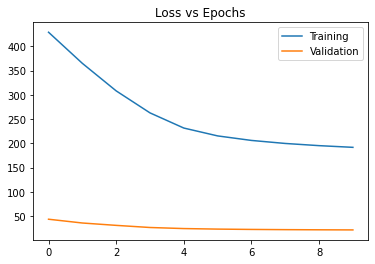

In [8]:
batch_size = 128
seq_len = 100
epochs = 10
lr = 0.01

train(model, trainset, batch_size, seq_len, epochs, lr=lr, valid=validset)

In [11]:
# checkpoint = {
#     'vocab'   : model.vocab,
#     'n_hidden': model.n_hidden,
#     'n_layers': model.n_layers,
#     'state'   : model.state_dict()
# }

# filepath = 'saved/LSTM_390_nodes_25_epochs.net'

# with open(filepath, 'wb') as f:
#     torch.save(checkpoint, f)

In [9]:
with open('saved/LSTM_390_nodes_25_epochs.net', 'rb') as f:
    checkpoint = torch.load(f)

model = Network(vocab, checkpoint['n_hidden'], checkpoint['n_layers'])
model.load_state_dict(checkpoint['state'])

<All keys matched successfully>

In [10]:
text = model.sample(2000, top_k=5)

In [11]:
print(text)

And Victoria sang the place,
was taken from the death of an old man's way. There was on the
part in their conversation again.

"Why, what would
I be seeking at once, and then, and help it? You know how it's a parlies when they
were a chance of mind, we may be to be my seren in the court." Stepan Arkadyevitch answered, as he reached.

"I don't want to see you! Take her all that was not yet to speak," she
said, and trying to spoil her and beginning to
get on the
strain of longing in them, with a smile,
and went on that he did not know herself. The prince came over him with a shirt, and went out onto the subject that humelously and hearing when the patched crowd was satisfeed with her father with her face. She had taken her lips with
these sight.

The princess wished to go to all that he would have taken up the consciousness of his own soul in the difficulty of
water that he had said this to his service, as she went into the sun were always delighted, and
would have been seeing it."

"Oh,